# Import required libraries

In [78]:
import pandas as pd
from datetime import datetime
import missingno as msno
import matplotlib.pyplot as plt

#### Load and read the data

In [79]:
food = pd.read_csv('food_orders_new_delhi.csv')
food.head()

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0


#### Clean the dataset for inconsistencies, missing values, or irrelevant information.


<Axes: >

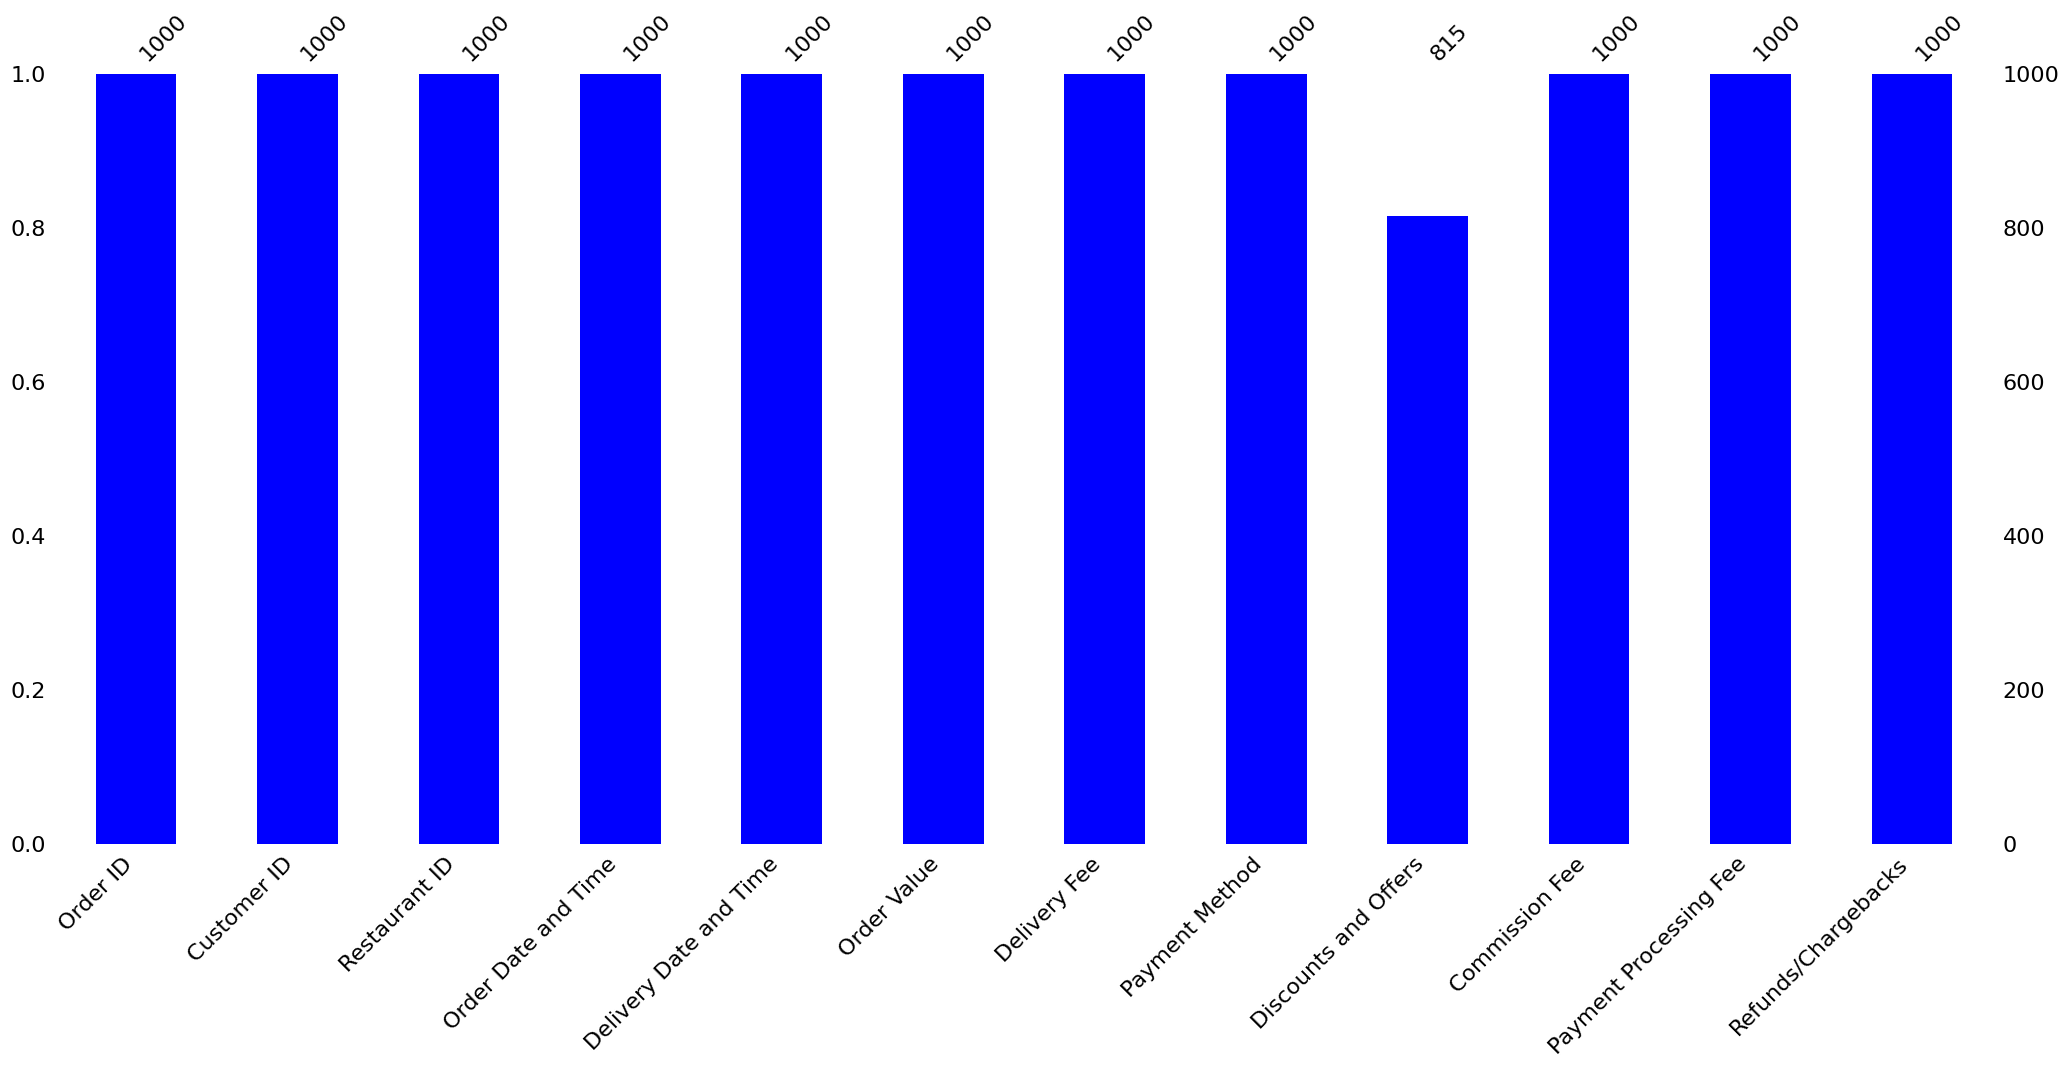

In [80]:
# Check if there are missing values on the dataset

msno.bar(food, color='blue')

In [81]:
# Look into 'Discounts and Offers' column to see what haapen

print(food['Discounts and Offers'].unique())

['5% on App' '10%' '15% New User' nan '50 off Promo']


In [82]:
# Since orders without discounts make nan values, we can fill the missing values in 'Discounts and Offers' column with 'None'

food['Discounts and Offers'].fillna('None', inplace=True)
print(food['Discounts and Offers'].unique())

['5% on App' '10%' '15% New User' 'None' '50 off Promo']


In [83]:
# Check datatypes of the dataset

print(food.dtypes)

Order ID                   int64
Customer ID               object
Restaurant ID             object
Order Date and Time       object
Delivery Date and Time    object
Order Value                int64
Delivery Fee               int64
Payment Method            object
Discounts and Offers      object
Commission Fee             int64
Payment Processing Fee     int64
Refunds/Chargebacks        int64
dtype: object


In [84]:
# Convert dtypes of the two date and time columns to datetime in order to analyze

food['Order Date and Time'] = pd.to_datetime(food['Order Date and Time'])
food['Delivery Date and Time'] = pd.to_datetime(food['Delivery Date and Time'])
food[['Order Date and Time', 'Delivery Date and Time']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order Date and Time     1000 non-null   datetime64[ns]
 1   Delivery Date and Time  1000 non-null   datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 15.8 KB


### Brief Summary
* Missing data in 'Discounts and Offers' column have been filled with 'none' which means there's no discount for the order.

* 'Order Date and Time' and 'Delivery Date and Time' columns have been converted to datetime format.

# 1. Detailed Cost Analysis

#### Identifying the major cost components associated with delivering food orders, including direct costs like delivery fees and indirect costs like discounts and payment processing fees.

In [85]:
# There are 5 kinds of Discount - '5% on App', '10%', '15% New User', '50 off Promo' and 'none'.
# So, we can create a function to extract numeric values from the 'Discounts and Offers' string in order to calculate the cost easily.

def extract_discount(discount_str):
    if 'off' in discount_str:
        # Fixed amount off
        return float(discount_str.split(' ')[0])
    elif '%' in discount_str:
        # Percentage off
        return float(discount_str.split('%')[0])
    else:
        # No discount
        return 0.0

In [86]:
# Apply the function to create a new 'Discount Value' column

food['Discount Percentage'] = food['Discounts and Offers'].apply(lambda x: extract_discount(x))

In [87]:

# Calculate the discount amount based on the order value for percentage discounts

food['Discount Amount'] = food.apply(lambda x: (x['Order Value'] * x['Discount Percentage'] / 100)
                                                   if x['Discount Percentage'] > 1
                                                   else x['Discount Percentage'], axis=1)


In [88]:
# Adjust 'Discount Amount' for fixed discounts directly specified in the 'Discounts and Offers' column

food['Discount Amount'] = food.apply(lambda x: x['Discount Amount'] if x['Discount Percentage'] <= 1
                                                   else x['Order Value'] * x['Discount Percentage'] / 100, axis=1)
print(food[['Order Value', 'Discounts and Offers', 'Discount Percentage', 'Discount Amount']].head())
print()
print(food.info())

   Order Value Discounts and Offers  Discount Percentage  Discount Amount
0         1914            5% on App                  5.0            95.70
1          986                  10%                 10.0            98.60
2          937         15% New User                 15.0           140.55
3         1463                 None                  0.0             0.00
4         1992         50 off Promo                 50.0           996.00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order ID                1000 non-null   int64         
 1   Customer ID             1000 non-null   object        
 2   Restaurant ID           1000 non-null   object        
 3   Order Date and Time     1000 non-null   datetime64[ns]
 4   Delivery Date and Time  1000 non-null   datetime64[ns]
 5   Order Value             

In [89]:
# Calculate direct, indirect and total costs 

food['Direct Cost'] = food['Delivery Fee']
food['Indirect Cost'] = food['Payment Processing Fee'] + food['Discount Amount']
food['Total Cost'] = food['Direct Cost'] + food['Indirect Cost']
food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order ID                1000 non-null   int64         
 1   Customer ID             1000 non-null   object        
 2   Restaurant ID           1000 non-null   object        
 3   Order Date and Time     1000 non-null   datetime64[ns]
 4   Delivery Date and Time  1000 non-null   datetime64[ns]
 5   Order Value             1000 non-null   int64         
 6   Delivery Fee            1000 non-null   int64         
 7   Payment Method          1000 non-null   object        
 8   Discounts and Offers    1000 non-null   object        
 9   Commission Fee          1000 non-null   int64         
 10  Payment Processing Fee  1000 non-null   int64         
 11  Refunds/Chargebacks     1000 non-null   int64         
 12  Discount Percentage     1000 non-null   float64  

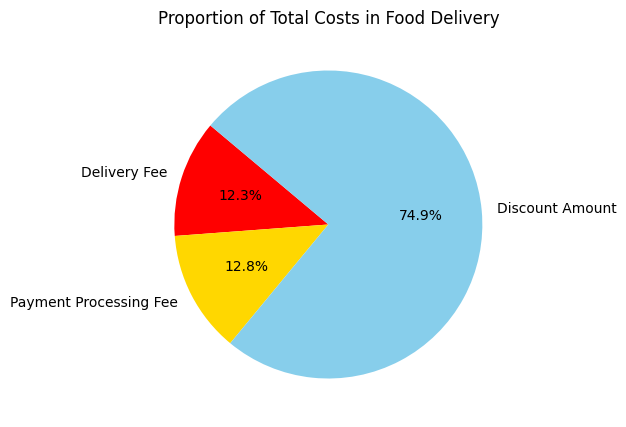

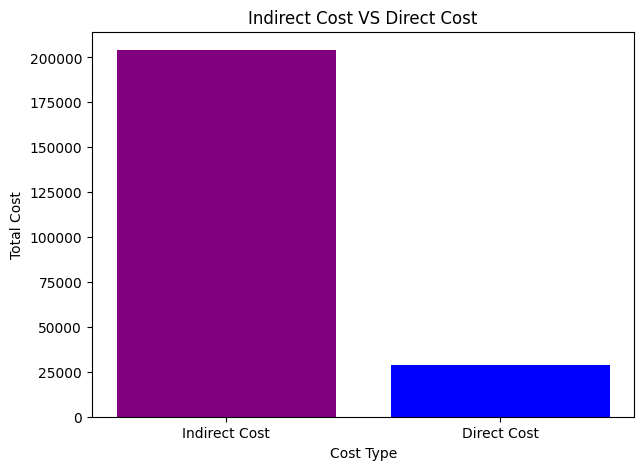

In [115]:
# Look into the proportion of the cost

# Figure 1 - Proportion of Total Costs
costs_detail = food[['Delivery Fee', 'Payment Processing Fee', 'Discount Amount']].sum()
plt.figure(figsize=(7, 5))
plt.pie(costs_detail, labels=costs_detail.index, autopct='%1.1f%%', startangle=140, colors=['red', 'gold', 'skyblue'])
plt.title('Proportion of Total Costs in Food Delivery')
plt.show()

# Figure 2 - Comparing indirect and direct cost
plt.figure(figsize=(7, 5)) 
plt.bar(x=['Indirect Cost', 'Direct Cost'], height=[food['Indirect Cost'].sum(), food['Direct Cost'].sum()], color=['purple', 'blue'])
plt.title('Indirect Cost VS Direct Cost')
plt.xlabel('Cost Type')
plt.ylabel('Total Cost')
plt.show()


### Brief Summary

* A new column, Discount Amount, has been calculated based on the Discounts and Offers column. This was achieved by extracting percentage discounts or fixed amounts and applying them to the order value.

* Figure 1 illustrates 'Discounts' constitute a significant portion of the costs. Likewise, Figure 2 shows that Indirect cost significantly higher than Direct cost. So we can assume that promotional strategies might be heavily impacting overall profitability.

# 2. Profitability Evaluation

#### Calculating the profitability of individual orders and aggregating this data to assess overall profitability. This involves examining how revenue generated from commission fees measures against the total costs.

In [116]:
# Calculate total costs and revenue per order

food['Total Cost'] = food['Delivery Fee'] + food['Commission Fee'] + food['Payment Processing Fee'] + food['Discount Amount']
food['Revenue'] = food['Commission Fee']
food['Profit'] = food['Revenue'] - food['Total Cost']

food.head()

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks,Discount Percentage,Discount Amount,Direct Cost,Indirect Cost,Total Cost,Revenue,Profit
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0,5.0,95.70,0,142.70,292.70,150,-142.70
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0,10.0,98.60,40,121.60,359.60,198,-161.60
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0,15.0,140.55,30,185.55,410.55,195,-215.55
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,None,146,27,0,0.0,0.00,50,27.00,223.00,146,-77.00
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0,50.0,996.00,30,1046.00,1206.00,130,-1076.00


In [117]:
# aggregate data to get overall metrics

total_orders = food.shape[0]
total_revenue = food['Revenue'].sum()
total_cost = food['Total Cost'].sum()
total_profit = food['Profit'].sum()

overall_metrics = {
    "Total Orders": total_orders,
    "Total Revenue": total_revenue,
    "Total Cost": total_cost,
    "Total Profit": total_profit
}

print(overall_metrics)

{'Total Orders': 1000, 'Total Revenue': 126990, 'Total Cost': 359699.85, 'Total Profit': -232709.84999999998}
